<a href="https://colab.research.google.com/github/satyhim/Capstone-Project-Predicting-sentiment-of-COVID-19-tweets/blob/main/Covid19_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Covid19 Tweet Sentiment analysis Using LSTM (Long short-term memory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('mode.chained_assignment', None)
palette=sns.color_palette('magma')
sns.set(palette=palette)

In [3]:
train_data=pd.read_csv('/content/drive/MyDrive/Python/Project/NLP_Covid19_tweet/Corona_NLP_train.csv', encoding='latin-1')
test_data=pd.read_csv('/content/drive/MyDrive/Python/Project/NLP_Covid19_tweet/Corona_NLP_test.csv', encoding='latin-1')

train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


#Exploring the data

In [4]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
train_data.shape

(41157, 6)

In [6]:
test_data.shape

(3798, 6)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


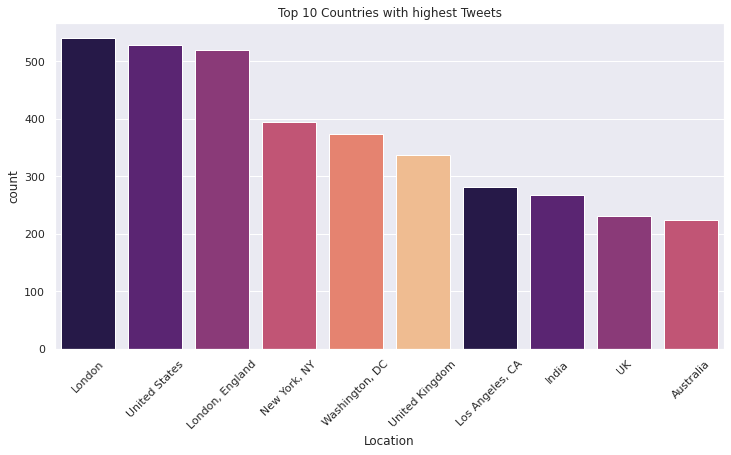

In [8]:
#Top 10 Countries that had the highest tweets
plt.figure(figsize=(12,6))
plt.title('Top 10 Countries with highest Tweets')
countries =sns.countplot(x='Location', data=train_data, order=train_data['Location'].value_counts().index[:10], palette=palette)
countries.set_xticklabels(countries.get_xticklabels(), rotation=45)
plt.show()

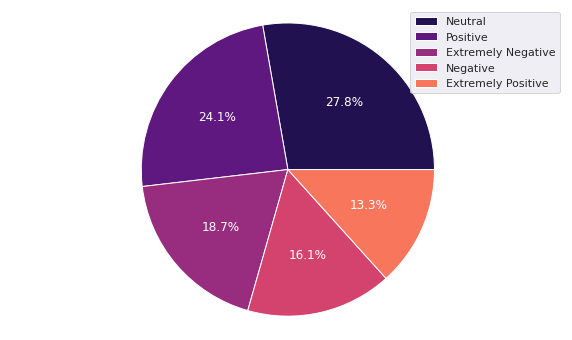

In [9]:
#Pie Chart for the Sentiments Percentage 
plt.figure(figsize=(10,6))
plt.pie(train_data['Sentiment'].value_counts(), labels=train_data['Sentiment'].unique(), autopct='%.1f%%', textprops={'color':"w"})
plt.legend(loc='upper right')
plt.axis('equal')
plt.show()

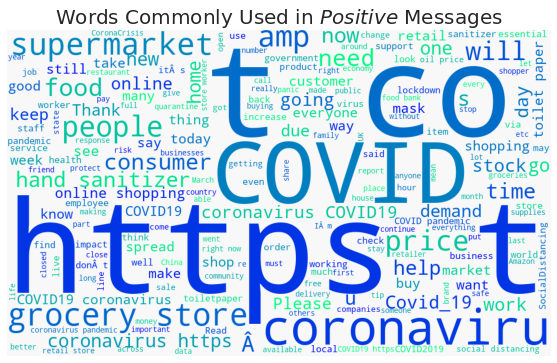

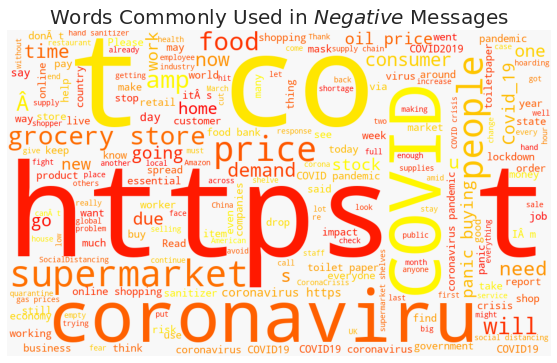

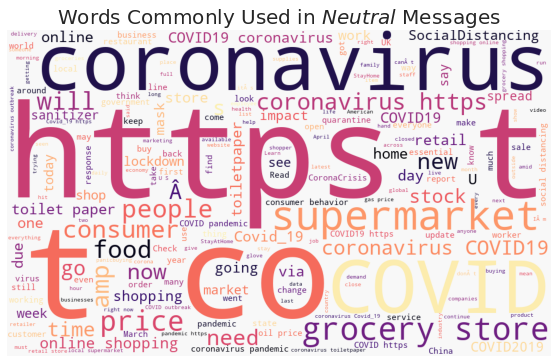

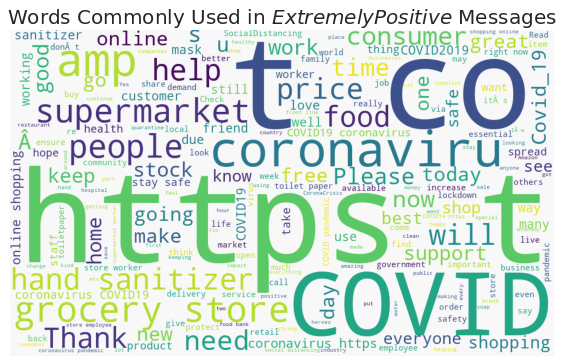

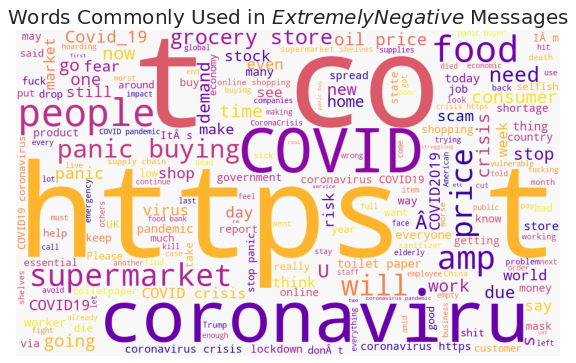

In [10]:
#WordCloud for the Sentiments
from wordcloud import WordCloud
for label, cmap in zip(['Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative'],
                       ['winter', 'autumn', 'magma', 'viridis', 'plasma']):
    text = train_data.query('Sentiment == @label')['OriginalTweet'].str.cat(sep=' ')
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
    plt.show()

In [11]:
#Only intrested in the OriginalTweet and Sentiment Columns
train_df= train_data[['OriginalTweet','Sentiment']]
test_df= test_data[['OriginalTweet','Sentiment']]

train_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


#Preprocessing

In [12]:
#Checking for null values
train_df.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [13]:
test_df.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [14]:
#Mapping the target column to {Negative/Neutral/Positive}
target_mapping={'Extremely Negative':0, 'Negative':0, 'Neutral':1,
                'Positive':2, 'Extremely Positive':2}
train_df['SentimentMapped']=train_df['Sentiment'].map(lambda x:target_mapping[x])
test_df['SentimentMapped']=test_df['Sentiment'].map(lambda x:target_mapping[x])

train_df.head()

,OriginalTweet,Sentiment,SentimentMapped
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1
1,advice Talk to your neighbours family to excha...,Positive,2
2,Coronavirus Australia: Woolworths to give elde...,Positive,2
3,My food stock is not the only one which is emp...,Positive,2
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


In [19]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
#Preprocessing the tweets
import string
import re
import nltk
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    #remove links starting with http
    text1 = re.sub(r'http\S+', ' ', text)
    #remove digits
    text2 = re.sub(r'\d+',' ', text1)
    tokens = re.split('\W+', text2)
    text = [word for word in tokens if word not in stopwords]
    return text

In [21]:
train_df['OriginalTweetClean'] = train_df['OriginalTweet'].apply(lambda x: clean_text(x))
test_df['OriginalTweetClean'] = test_df['OriginalTweet'].apply(lambda x: clean_text(x))

train_df.head()

,OriginalTweet,Sentiment,SentimentMapped,OriginalTweetClean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1,"[menyrbie, philgahan, chrisitv, ]"
1,advice Talk to your neighbours family to excha...,Positive,2,"[advice, talk, neighbours, family, exchange, p..."
2,Coronavirus Australia: Woolworths to give elde...,Positive,2,"[coronavirus, australia, woolworths, give, eld..."
3,My food stock is not the only one which is emp...,Positive,2,"[food, stock, one, empty, please, dont, panic,..."
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,"[ready, go, supermarket, covid, outbreak, im, ..."


In [22]:
X_train = train_df['OriginalTweetClean']
X_test = test_df['OriginalTweetClean']

y_train = train_df['SentimentMapped']
y_test = test_df['SentimentMapped']

In [23]:
#OneHot Encoding the target column
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_test.head()

,0,1,2
0,1,0,0
1,0,0,1
2,0,0,1
3,1,0,0
4,0,1,0


In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#The maximum number of words to be used(most frequent)
MAX_NB_WORDS = 10000
#Max number of words in each Tweet
MAX_SEQUENCE_LENGTH = 100


# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

In [25]:
#Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq[10]

[361,
 2703,
 3977,
 125,
 334,
 754,
 1599,
 169,
 576,
 2031,
 451,
 73,
 243,
 2992,
 5384,
 703,
 6,
 58,
 1,
 5682,
 2]

In [26]:
#Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq,44)
X_test_seq_padded = pad_sequences(X_test_seq,44)

X_train_seq_padded[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  361, 2703, 3977,  125,  334,  754, 1599,  169,  576, 2031,
        451,   73,  243, 2992, 5384,  703,    6,   58,    1, 5682,    2],
      dtype=int32)

In [27]:
print('X_train_seq_padded:', X_train_seq_padded.shape)
print('X_test_seq_padded:', X_test_seq_padded.shape)

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train_seq_padded: (41157, 44)
X_test_seq_padded: (3798, 44)
y_train: (41157, 3)
y_test: (3798, 3)


#Model Building

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping


model=Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=X_train_seq_padded.shape[1]))
#input_dim: Size of the vocabulary.
#output_dim: Dimension of the dense embedding.

model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

model.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

model.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 44, 64)            640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 44, 64)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 44, 128)           98816     
                                                                 
 lstm_1 (LSTM)               (None, 44, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                        

In [29]:
#Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Adding an early stopping
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=4, #Stop the model training if the validation accuracy doesnt increase in 4 consecutive Epochs
                   restore_best_weights=True)

In [30]:
#Fit the RNN
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=100, callbacks =[es],
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/100
1287/1287 [==============================] - 524s 399ms/step - loss: 0.7470 - accuracy: 0.6644 - val_loss: 0.5113 - val_accuracy: 0.8178
Epoch 2/100
1287/1287 [==============================] - 516s 401ms/step - loss: 0.4292 - accuracy: 0.8538 - val_loss: 0.4761 - val_accuracy: 0.8394
Epoch 3/100
1287/1287 [==============================] - 509s 396ms/step - loss: 0.3670 - accuracy: 0.8805 - val_loss: 0.4717 - val_accuracy: 0.8447
Epoch 4/100
1287/1287 [==============================] - 503s 391ms/step - loss: 0.3277 - accuracy: 0.8951 - val_loss: 0.4755 - val_accuracy: 0.8378
Epoch 5/100
1287/1287 [==============================] - 512s 398ms/step - loss: 0.2983 - accuracy: 0.9043 - val_loss: 0.5227 - val_accuracy: 0.8270
Epoch 6/100
1287/1287 [==============================] - 503s 391ms/step - loss: 0.2780 - accuracy: 0.9122 - val_loss: 0.5069 - val_accuracy: 0.8360
Epoch 7/100
1287/1287 [==============================] - 507s 394ms/step - loss: 0.2680 - accuracy: 0.9178

#Evaluation

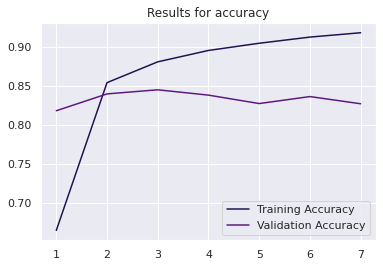

In [31]:
#Ploting the accuracy metric across the epochs
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

In [32]:
score = model.evaluate(X_test_seq_padded,y_test, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]) 


Test loss: 0.4717375338077545
Test accuracy: 0.8446550965309143
